Training model...
82.681099
3.1290727
i=1		pred_trad:82.681099	pred_online:3.129073	correct:91.00		RMSE_pred:8.318900999999997	RMSE_online:87.870927333831787
80.00029


KeyboardInterrupt: 

Process Process-135:
  File "<ipython-input-58-6409d4c7730a>", line 50, in train_model
    regressor_DBN = SupervisedDBNRegression.load(model_name)
Traceback (most recent call last):
  File "/srv/conda/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/srv/conda/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/jovyan/models/deep-belief-network/dbn/tensorflow/models.py", line 46, in load
    return cls.from_dict(dct_to_load)
  File "/home/jovyan/models/deep-belief-network/dbn/tensorflow/models.py", line 328, in from_dict
    setattr(instance, 'unsupervised_dbn', instance.unsupervised_dbn_class.from_dict(unsupervised_dbn_dct))
  File "/home/jovyan/models/deep-belief-network/dbn/tensorflow/models.py", line 272, in from_dict
    setattr(instance, 'rbm_layers', [instance.rbm_class.from_dict(rbm) for rbm in rbm_layers])
  File "/home/jovyan/models/deep-belief-network/dbn/tensorflow/m

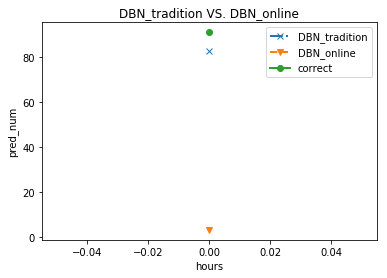

  File "/srv/conda/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1104, in internal_convert_to_tensor
    ret = conversion_func(value, dtype=dtype, name=name, as_ref=as_ref)
  File "/srv/conda/lib/python3.6/site-packages/tensorflow/python/framework/constant_op.py", line 235, in _constant_tensor_conversion_function
    return constant(v, dtype=dtype, name=name)
  File "/srv/conda/lib/python3.6/site-packages/tensorflow/python/framework/constant_op.py", line 220, in constant
    name=name).outputs[0]
  File "/srv/conda/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3392, in create_op
    op_def=op_def)
  File "/srv/conda/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1734, in __init__
    control_input_ops)
  File "/srv/conda/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1564, in _create_c_op
    c_api.TF_SetAttrValueProto(op_desc, compat.as_str(name), serialized)
KeyboardInterrupt


In [58]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics.regression import r2_score, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import AdaBoostRegressor
# import GridSearchCV
import xlrd
import math
import matplotlib.pyplot as plt
import logging
import os
import sys
import pandas as pd
from sklearn import svm
# from queue import Queue
from threading import Thread
from multiprocessing import Process, Queue
import os
import datetime

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
# 默认为0：输出所有log信息
# 设置为1：进一步屏蔽INFO信息
# 设置为2：进一步屏蔽WARNING信息
# 设置为3：进一步屏蔽ERROR信息

np.random.seed(1337)  # for reproducibility
logging.basicConfig(level=logging.INFO)


def train_model(learning_rate_rbm, learning_rate, batch_size, x_train, y_train, x_test, message_queue, model_name,
                is_fit, is_predict):
    # path_DBN = os.path.join(os.path.join(os.path.dirname(os.path.abspath(__file__)), "models"), "deep-belief-network")
    path_DBN = os.path.join(os.path.join(os.getcwd(), "models"), "deep-belief-network")
    sys.path.append(path_DBN)
    from dbn.tensorflow import SupervisedDBNRegression

    regressor_DBN = SupervisedDBNRegression(hidden_layers_structure=[10000, 2000, 1000, 500, 200, 100, 20],
                                            learning_rate_rbm=learning_rate_rbm,
                                            learning_rate=learning_rate,
                                            n_epochs_rbm=5,
                                            n_iter_backprop=2,
                                            batch_size=batch_size,
                                            activation_function='sigmoid',
                                            verbose=False)
    # dict = dict_queue.get()

    if os.path.exists(model_name):
        # regressor_DBN.from_dict(dict)
        regressor_DBN = SupervisedDBNRegression.load(model_name)

    if is_fit:
        regressor_DBN.fit(x_train, y_train)

    # dict_queue.put(regressor_DBN.to_dict())
    regressor_DBN.save(model_name)
    # print("save ready")

    if is_predict:
        pred = regressor_DBN.predict(x_test)
        message_queue.put(pred)
    # print(regressor_DBN.predict(x_train))
    return


def train_model_func(learning_rate_rbm, learning_rate, batch_size, feature, label, path_out_png, path_out_txt,
                     train_deep, start_predict, offline_predictions):
    print("Training model...")

    corrects = []
    predictions_trandition = []
    predictions_online = []
    RMSEs_trandition = []
    RMSEs_online = []
    dict_trandition = None
    dict_online = None
    #is_fit_trandition = True
    is_predict = False
    model_name_trandition = 'model_tradition.pkl'
    model_name_online = 'model_online.pkl'

    if os.path.exists(model_name_trandition):
        os.remove(model_name_trandition)
    if os.path.exists(model_name_online):
        os.remove(model_name_online)

    for i in range(train_deep, label.shape[0]):
        #x_train_trandition = np.array(feature[0:start_predict + train_deep])
        #y_trian_trandition = np.array(label[0:start_predict + train_deep])
        x_train_online = np.array(feature[i - train_deep:i])
        y_trian_online = np.array(label[i - train_deep:i])
        x_test = np.array(feature[i])
        y_test = np.array(label[i:i + 1])[0]

        '''x_train_trandition = (x_train_trandition - x_train_trandition.min()) / (
        x_train_trandition.max() - x_train_trandition.min())
        x_train_online = (x_train_online - x_train_online.min()) / (x_train_online.max() - x_train_online.min())
        x_test = (x_test - x_test.min()) / (x_test.max() - x_test.min())'''

        message_queue = Queue()
        # dict_queue = Queue()

        if i >= start_predict + train_deep:
            is_predict = True

        # dict_queue.put(dict_trandition)
        #_process = Process(target=train_model, args=(
         #   learning_rate_rbm, learning_rate, batch_size, x_train_trandition, y_trian_trandition, x_test,
          #  message_queue, model_name_trandition, is_fit_trandition, is_predict))
        #_process.start()
        #_process.join()
        if is_predict:
            #prediction_trandition = message_queue.get()[0][0]
            prediction_trandition = np.array(offline_predictions[i:i+1])[0]
            #print(prediction_trandition)
        # dict_trandition = dict_queue.get()
        #is_fit_trandition = False

        # dict_queue.put(dict_online)
        _process = Process(target=train_model, args=(
            learning_rate_rbm, learning_rate, batch_size, x_train_online, y_trian_online, x_test, message_queue,
            model_name_online, True, is_predict))
        _process.start()
        _process.join()
        if is_predict:
            prediction_online = message_queue.get()[0][0]
            #print(prediction_online)
        # dict_online = dict_queue.get()

        if is_predict:
            corrects.append(y_test)
            predictions_trandition.append(prediction_trandition)
            predictions_online.append(prediction_online)

            RMSE_trandition = math.sqrt(mean_squared_error(corrects, predictions_trandition))
            RMSE_online = math.sqrt(mean_squared_error(corrects, predictions_online))

            RMSEs_trandition.append(RMSE_trandition)
            RMSEs_online.append(RMSE_online)

            with open(path_out_txt, 'a') as f:
                f.write("pred_trad:%f\tpred_online:%f\tcorrect:%.2f\t\tRMSE_pred:%.15f\tRMSE_online:%.15f" % (
                    prediction_trandition, prediction_online, y_test, RMSE_trandition, RMSE_online,))

            print("i=%d\t\tpred_trad:%f\tpred_online:%f\tcorrect:%.2f\t\tRMSE_pred:%.15f\tRMSE_online:%.15f" % (
                i, prediction_trandition, prediction_online, y_test, RMSE_trandition, RMSE_online,))

            x_range = range(i - train_deep - start_predict + 1)
            plt.clf()
            '''plt.ylabel('RMSE')
            plt.xlabel('hours')
            plt.title("DBN_tradition VS. DBN_online")
            plt.plot(x_range, RMSEs_trandition, marker='o', label="DBN_tradition")
            plt.plot(x_range, RMSEs_online, marker='o', label="DBN_online")'''
            plt.ylabel('pred_num')
            plt.xlabel('hours')
            plt.title("DBN_tradition VS. DBN_online")
            plt.plot(x_range, predictions_trandition, ls='-.', lw=2, marker='x', label="DBN_tradition")
            plt.plot(x_range, predictions_online, ls='--', lw=2, marker='v', label="DBN_online")
            plt.plot(x_range, corrects,ls='-', lw=2, marker='o', label="correct")
            plt.legend(loc='best')
            plt.savefig(path_out_png)
        else:
            print("i=",i)

    print('Done.\nDBN_pred:\tR-squared: %f\nMSE: %f' % (
        r2_score(corrects, predictions_trandition), mean_squared_error(corrects, predictions_trandition)))
    print('DBN_online:\tR-squared: %f\nMSE: %f' % (
        r2_score(corrects, predictions_online), mean_squared_error(corrects, predictions_online)))


def main(data, target, offline_predictions, path_out_png, path_out_txt, learning_rate_rbm=0.001, learning_rate=0.001, batch_size=2,
         train_deep=1, step=100):
    feature = np.array([])
    for start in range(step, data.shape[0] + 1):
        feature = np.append(feature, data[start - step:start].values)
    label = target[step - 1:]
    feature = feature.reshape(label.shape[0], math.floor(feature.size / label.shape[0]))
    
    #print(data.shape)
    #print(feature.shape)
    #print(target.shape)
    #print(label.shape)
    #print(np.array(data[0:1]))
    #print(np.array(feature[0:1]))
    #print(np.array(target[3:10]))
    #print(np.array(label[0:10]))
    
    
    #print(target[45:60])
    #print(label[45:60])
    
    offline_predictions = offline_predictions[step - 1:]
    #print(np.array(label[48:60]))
    #print(np.array(offline_predictions[48:60]))

    train_model_func(learning_rate_rbm=learning_rate_rbm, learning_rate=learning_rate, batch_size=batch_size,
                     feature=feature, label=label, path_out_png=path_out_png, path_out_txt=path_out_txt,
                     train_deep=train_deep, start_predict=50, offline_predictions=offline_predictions)


if __name__ == "__main__":
    path_out_png = "out/out.png"
    path_out_txt = "out/out.txt"
    open(path_out_txt, 'w').close()

    path_data = "data/airdata.csv"
    data = pd.read_csv(path_data, sep=",")

    # print(type(data['date'][0]))

    target = data["pm25"]
    target = target.drop([0])

    data = data.drop([data.shape[0] - 1])
    data = data.drop(["date"], axis=1)

    for col_name in data.columns:
        data[col_name] = (data[col_name] - data[col_name].min()) / (data[col_name].max() - data[col_name].min())

    # min_max_scaler = MinMaxScaler()
    # data = min_max_scaler.fit_transform(data)

    # print(type(data))
    
    path_offline_predictions = "data/offline_predictions.txt"
    offline_predictions = pd.read_csv(path_offline_predictions, sep=" ")
    
    #print(offline_predictions.head(60))
    #print(offline_predictions['pred'])
    #print(target.head(60))
    #print(target[50:56])
    offline_predictions = offline_predictions['pred'][1:]
    #print(offline_predictions[50:60])
    #print(target[:10])
    
    

    sys.exit(main(data=data, target=target, offline_predictions=offline_predictions, path_out_png=path_out_png, path_out_txt=path_out_txt))
